# Machine Learning 2 — Assignment #1

**Universidad de Antioquia**

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (silhouette_score, davies_bouldin_score,
                              rand_score, adjusted_rand_score)

np.random.seed(42)

---
# Assignment 1: Implement Gaussian Mixture Model (GMM)

**Tasks:**
1. Implement the GMM algorithm from scratch — no scikit-learn GMM.
2. Fit the GMM to both datasets (FIFA 25 Players and East West Airlines).
3. Evaluate results using the Rand Index and qualitative methods (scatter plots, bar charts).

## 1.1 GMM — Implementation from scratch

La implementacion sigue el algoritmo EM en tres pasos:
- **E-step** (`expectation_step`): calcula las responsabilidades γ₍ₙₖ₎.
- **M-step** (`maximization_step`): actualiza los parametros π, μ y Σ.
- **`compute_log_likelihood`**: monitorea la convergencia del algoritmo.

La clase `GMM` envuelve estas funciones para un uso reutilizable sobre ambos datasets.

In [2]:
epsilon = 1e-6

def generate_positive_definite_matrix(d):
    A = np.random.randn(d, d)
    return np.dot(A, A.T) + np.eye(d) * epsilon

def ensure_positive_definite(Sigma):
    return Sigma + np.eye(Sigma.shape[0]) * epsilon

def expectation_step(X, mu, Sigma, pi, K):
    """E-step: calcula responsabilidades gamma dado los parametros actuales."""
    n = X.shape[0]
    gamma = np.zeros((n, K))
    for k in range(K):
        try:
            gamma[:, k] = pi[k] * multivariate_normal.pdf(
                X, mean=mu[k], cov=ensure_positive_definite(Sigma[k]))
        except np.linalg.LinAlgError:
            Sigma[k] = ensure_positive_definite(Sigma[k])
            gamma[:, k] = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k])
    gamma += epsilon
    gamma /= gamma.sum(axis=1, keepdims=True)
    return gamma

def maximization_step(X, gamma, K):
    """M-step: actualiza pi, mu y Sigma a partir de las responsabilidades."""
    n, d = X.shape
    Nk        = gamma.sum(axis=0)
    pi_new    = Nk / n
    mu_new    = np.dot(gamma.T, X) / Nk[:, np.newaxis]
    Sigma_new = np.zeros((K, d, d))
    for k in range(K):
        X_centered   = X - mu_new[k]
        Sigma_new[k] = np.dot(gamma[:, k] * X_centered.T, X_centered) / Nk[k]
        Sigma_new[k] = ensure_positive_definite(Sigma_new[k])
    return pi_new, mu_new, Sigma_new

def compute_log_likelihood(X, pi, mu, Sigma, K):
    """Log-likelihood para monitorear la convergencia del EM."""
    log_likelihood = 0
    for k in range(K):
        try:
            prob  = pi[k] * multivariate_normal.pdf(
                X, mean=mu[k], cov=ensure_positive_definite(Sigma[k]))
            prob += epsilon
            log_likelihood += np.sum(np.log(prob))
        except np.linalg.LinAlgError:
            Sigma[k] = ensure_positive_definite(Sigma[k])
            prob = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k]) + epsilon
            log_likelihood += np.sum(np.log(prob))
    return log_likelihood


class GMM:
    """
    Gaussian Mixture Model implementado desde cero con el algoritmo EM.
    No utiliza la implementacion de sklearn.
    Pasos: expectation_step (E) -> maximization_step (M) -> compute_log_likelihood.
    """
    def __init__(self, n_components=3, max_iters=100, tol=1e-4):
        self.K         = n_components
        self.max_iters = max_iters
        self.tol       = tol

    def fit(self, X):
        n, d = X.shape
        K    = self.K
        self.pi    = np.ones(K) / K
        idx        = np.random.choice(n, K, replace=False)
        self.mu    = X[idx, :]
        self.Sigma = np.array([generate_positive_definite_matrix(d) for _ in range(K)])
        self.log_likelihoods_ = []
        prev_ll = -np.inf
        for _ in range(self.max_iters):
            gamma                        = expectation_step(X, self.mu, self.Sigma, self.pi, K)
            self.pi, self.mu, self.Sigma = maximization_step(X, gamma, K)
            ll                           = compute_log_likelihood(X, self.pi, self.mu, self.Sigma, K)
            self.log_likelihoods_.append(ll)
            if np.abs(ll - prev_ll) < self.tol:
                break
            prev_ll = ll
        self.gamma_ = gamma
        return self

    def predict(self, X):
        gamma = expectation_step(X, self.mu, self.Sigma, self.pi, self.K)
        return np.argmax(gamma, axis=1)

    def score(self, X):
        return compute_log_likelihood(X, self.pi, self.mu, self.Sigma, self.K)

print("GMM listo.")

GMM listo.


### 1.1.1 Verification on Iris dataset

Se verifica que el GMM converge correctamente y produce clusters coherentes comparados con las etiquetas reales del dataset Iris.

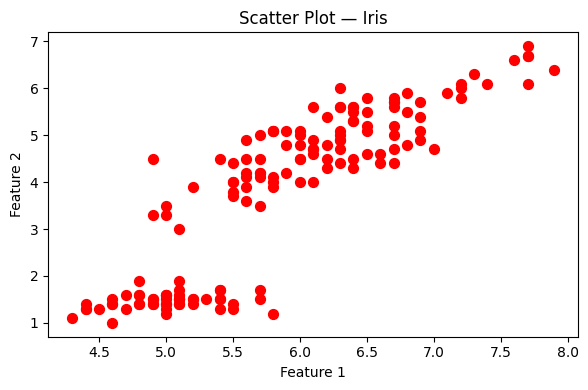

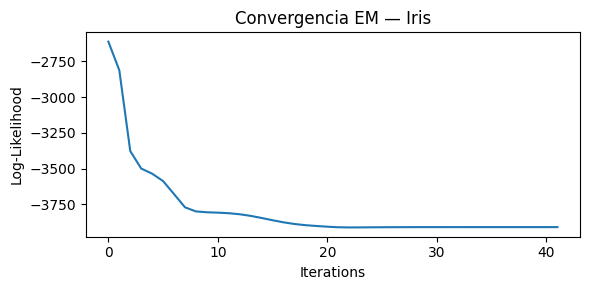

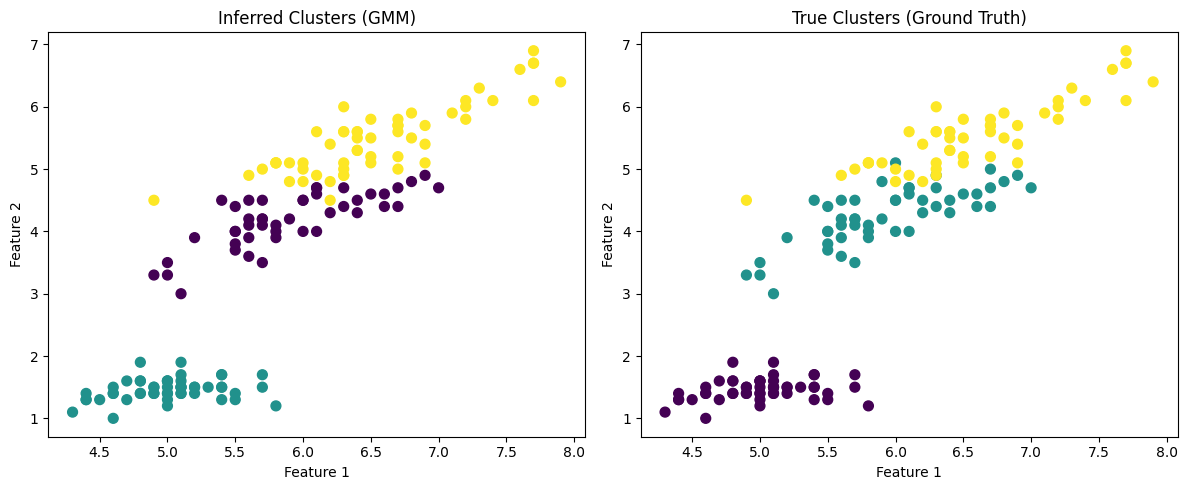

Rand Score (Iris): 0.9575


In [3]:
X_iris, y_iris = load_iris(return_X_y=True)
X_2d = X_iris[:, [0, 2, 1, 3]]

plt.figure(figsize=(6, 4))
plt.scatter(X_2d[:, 0], X_2d[:, 1], marker='o', color='r', s=50)
plt.xlabel('Feature 1'); plt.ylabel('Feature 2')
plt.title('Scatter Plot — Iris')
plt.tight_layout(); plt.show()

gmm_iris = GMM(n_components=3, max_iters=100, tol=1e-4)
gmm_iris.fit(X_2d)
Z = gmm_iris.predict(X_2d)

plt.figure(figsize=(6, 3))
plt.plot(gmm_iris.log_likelihoods_)
plt.xlabel('Iterations'); plt.ylabel('Log-Likelihood')
plt.title('Convergencia EM — Iris')
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(X_2d[:, 0], X_2d[:, 1], c=Z, cmap='viridis', s=50)
ax[0].set_title('Inferred Clusters (GMM)')
ax[0].set_xlabel('Feature 1'); ax[0].set_ylabel('Feature 2')
ax[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y_iris, cmap='viridis', s=50)
ax[1].set_title('True Clusters (Ground Truth)')
ax[1].set_xlabel('Feature 1'); ax[1].set_ylabel('Feature 2')
plt.tight_layout(); plt.show()

print(f'Rand Score (Iris): {rand_score(y_iris, Z):.4f}')

## 1.2 Evaluation metrics

Funcion compartida que calcula las cuatro metricas para cualquier resultado de clustering.

In [4]:
def evaluar_clustering(X, labels, y_true, nombre, inertia=None):
    sil = silhouette_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    ri  = rand_score(y_true, labels)
    ari = adjusted_rand_score(y_true, labels)
    return {
        'Metodo'             : nombre,
        'Silhouette ↑'       : round(sil, 4),
        'Davies-Bouldin ↓'   : round(db,  4),
        'Inercia ↓'          : round(inertia, 2) if inertia is not None else 'N/A',
        'Rand Index ↑'       : round(ri,  4),
        'Adj. Rand Index ↑'  : round(ari, 4),
    }

Pasamos de datos morfológicos simples (Iris) a un espacio multidimensional complejo que mezcla propiedades de los elementos del dataset, como rendimiento técnico, físico, valor de mercado.

## 1.3 Dataset: FIFA 25 Players

**Objetivo:** agrupar jugadores por habilidades y estilo de juego.

**Features:** Age, Overall rating, Potential, Value, Wage, Height, Weight, Weak foot, Skill moves, International reputation.

**Numero de clusters:** el dataset tiene 4 categorias de posicion conocidas (Portero, Defensa, Mediocampista, Delantero), por lo que el valor por defecto es `K_FIFA = 4`. Se incluye un rango `k_range_fifa` para explorar valores cercanos antes de confirmar la eleccion.

### 1.3.1 Preprocessing

In [7]:
!gdown '1hKtD7CoVo6B2i4knYg0PxKxkVT1Ak6AJ' -O 'FIFA_official_data.xlsx'

Downloading...
From: https://drive.google.com/uc?id=1hKtD7CoVo6B2i4knYg0PxKxkVT1Ak6AJ
To: /Users/camilo/udea/ Machine_Learning_II/FIFA_official_data.xlsx
100%|██████████████████████████████████████| 9.34M/9.34M [00:00<00:00, 16.9MB/s]


In [ ]:
# df_fifa = pd.read_csv('fifa_df.csv', low_memory=False)
df_fifa = pd.read_excel('FIFA_official_data.xlsx')

def parse_money(s):
    if pd.isna(s): return np.nan
    s = str(s).replace('€', '').strip()
    if 'M' in s: return float(s.replace('M', '')) * 1e6
    if 'K' in s: return float(s.replace('K', '')) * 1e3
    try: return float(s)
    except: return np.nan

df_fifa['value_num'] = df_fifa['Value'].apply(parse_money)
df_fifa['wage_num']  = df_fifa['Wage'].apply(parse_money)
# df_fifa['age']       = (pd.Timestamp.now() -
#                         pd.to_datetime(df_fifa['dob'], errors='coerce')).dt.days // 365

features_fifa = ['Best Overall', 'Potential', 'value_num', 'wage_num',
                 'height_cm', 'weight_kg', 'weak_foot', 'skill_moves',
                 'international_reputation']

for col in features_fifa:
    df_fifa[col] = pd.to_numeric(df_fifa[col], errors='coerce')

df_clean    = df_fifa[features_fifa + ['positions', 'name']].dropna()
X_fifa_raw  = df_clean[features_fifa].values.astype(float)
scaler_fifa = StandardScaler()
X_fifa      = scaler_fifa.fit_transform(X_fifa_raw)

# Etiqueta de posicion (usada como referencia para el Rand Index)
def categorize_position(pos):
    pos = str(pos)
    if 'GK' in pos: return 0
    if any(p in pos for p in ['CB', 'LB', 'RB', 'LWB', 'RWB']): return 1
    if any(p in pos for p in ['CDM', 'CM', 'CAM', 'LM', 'RM']): return 2
    return 3

y_fifa      = df_clean['positions'].apply(categorize_position).values
pos_nombres = {0: 'Portero', 1: 'Defensa', 2: 'Mediocampista', 3: 'Delantero'}

print(f"Jugadores disponibles: {X_fifa.shape[0]}")
print(pd.Series(y_fifa).map(pos_nombres).value_counts().to_string())
df_clean[features_fifa].describe()

KeyError: 'overall_rating'

### 1.3.2 Elbow and Silhouette — choosing K_FIFA

Se exploran valores de k alrededor de 4 (Posiciones conocidas en el fútbol: Portero, defensa, mediocampo, delantero) para confirmar o ajustar la elección.

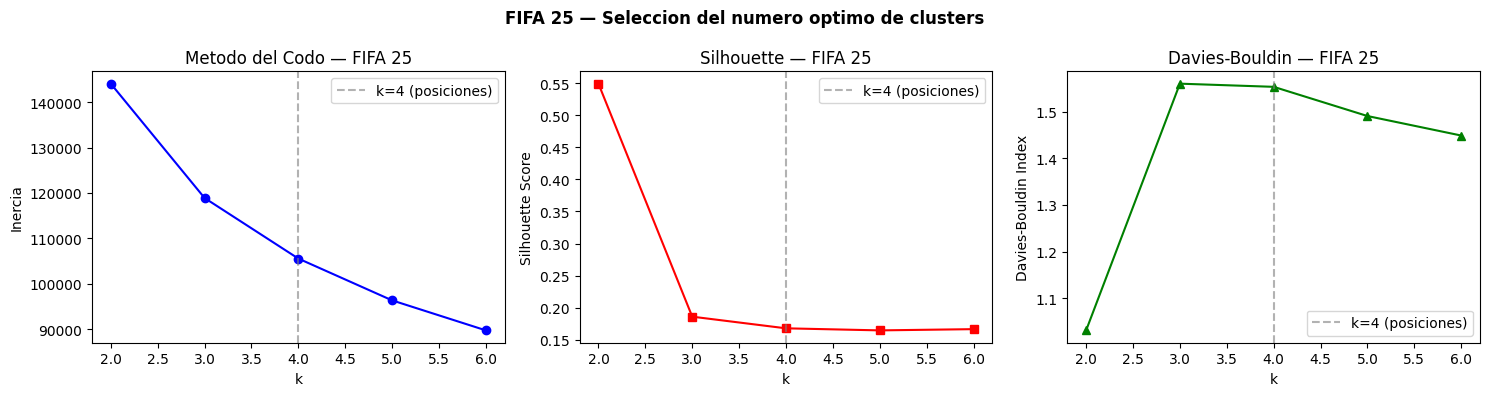

 k |    Inercia | Silhouette | DB Index
----------------------------------------
 2 |  144033.90 |     0.5495 |   1.0308
 3 |  118901.13 |     0.1858 |   1.5602
 4 |  105579.57 |     0.1676 |   1.5534 <-- 4 posiciones
 5 |   96387.73 |     0.1644 |   1.4907
 6 |   89792.00 |     0.1664 |   1.4489


In [ ]:
# Rango a explorar. Por defecto alrededor de las 4 posiciones conocidas.
# Puedes ampliarlo si quieres comparar mas opciones (ej: range(2, 9)).
k_range_fifa = range(2, 7)

inertias_fifa_1    = []
silhouettes_fifa_1 = []
db_scores_fifa_1   = []

for k in k_range_fifa:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_fifa)
    inertias_fifa_1.append(km.inertia_)
    silhouettes_fifa_1.append(silhouette_score(X_fifa, km.labels_))
    db_scores_fifa_1.append(davies_bouldin_score(X_fifa, km.labels_))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(list(k_range_fifa), inertias_fifa_1,    'bo-')
axes[0].axvline(x=4, color='gray', linestyle='--', alpha=0.6, label='k=4 (posiciones)')
axes[0].set_xlabel('k'); axes[0].set_ylabel('Inercia')
axes[0].set_title('Metodo del Codo — FIFA 25'); axes[0].legend()
axes[1].plot(list(k_range_fifa), silhouettes_fifa_1, 'rs-')
axes[1].axvline(x=4, color='gray', linestyle='--', alpha=0.6, label='k=4 (posiciones)')
axes[1].set_xlabel('k'); axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette — FIFA 25'); axes[1].legend()
axes[2].plot(list(k_range_fifa), db_scores_fifa_1,   'g^-')
axes[2].axvline(x=4, color='gray', linestyle='--', alpha=0.6, label='k=4 (posiciones)')
axes[2].set_xlabel('k'); axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin — FIFA 25'); axes[2].legend()
plt.suptitle('FIFA 25 — Seleccion del numero optimo de clusters', fontweight='bold')
plt.tight_layout(); plt.show()

print(f"{'k':>2} | {'Inercia':>10} | {'Silhouette':>10} | {'DB Index':>8}")
print('-' * 40)
for i, k in enumerate(k_range_fifa):
    mark = ' <-- 4 posiciones' if k == 4 else ''
    print(f"{k:>2} | {inertias_fifa_1[i]:>10.2f} | {silhouettes_fifa_1[i]:>10.4f} | {db_scores_fifa_1[i]:>8.4f}{mark}")

### 1.3.3 K selection — FIFA 25

> **Instruccion:** observa las graficas y la tabla anteriores, luego confirma o ajusta `K_FIFA`.

| Grafica | Que buscar | Senal del k optimo |
|---|---|---|
| Metodo del Codo | Punto donde la inercia deja de caer abruptamente | El codo de la curva |
| Silhouette Score | Maximo de la curva | k con el valor mas alto |
| Davies-Bouldin | Minimo de la curva | k con el valor mas bajo |

- **Metodo del Codo:** *(completar)*
- **Silhouette Score:** *(completar)*
- **Davies-Bouldin:** *(completar)*

**→ k elegido: `K_FIFA = ___`** — *(justificar. Por defecto = 4 porque corresponde a las 4 posiciones reales)*

### 1.3.4 Clustering — K-Means and GMM

> Actualiza `K_FIFA` con el valor elegido en la seccion 1.3.3 y ejecuta esta celda.

K_FIFA = 4
Distribucion K-Means: [4660 6326  547 6666]
Distribucion GMM:     [ 1462   101    17 16619]


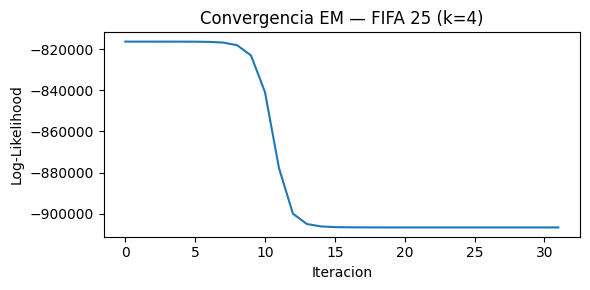

In [ ]:
# Valor por defecto: 4 (alineado con las 4 posiciones reales del dataset).
# Cambia este valor si el analisis del Elbow/Silhouette sugiere otro k.
K_FIFA = 4

km_fifa        = KMeans(n_clusters=K_FIFA, random_state=42, n_init=10)
labels_km_fifa = km_fifa.fit_predict(X_fifa)

gmm_fifa = GMM(n_components=K_FIFA, max_iters=200)
gmm_fifa.fit(X_fifa)
labels_gmm_fifa = gmm_fifa.predict(X_fifa)

print(f'K_FIFA = {K_FIFA}')
print('Distribucion K-Means:', np.bincount(labels_km_fifa))
print('Distribucion GMM:    ', np.bincount(labels_gmm_fifa))

plt.figure(figsize=(6, 3))
plt.plot(gmm_fifa.log_likelihoods_)
plt.xlabel('Iteracion'); plt.ylabel('Log-Likelihood')
plt.title(f'Convergencia EM — FIFA 25 (k={K_FIFA})')
plt.tight_layout(); plt.show()

### 1.3.5 Quantitative evaluation — Rand Index and metrics

In [ ]:
res_km_fifa  = evaluar_clustering(X_fifa, labels_km_fifa,  y_fifa, 'K-Means', inertia=km_fifa.inertia_)
res_gmm_fifa = evaluar_clustering(X_fifa, labels_gmm_fifa, y_fifa, 'GMM')

df_metricas_fifa = pd.DataFrame([res_km_fifa, res_gmm_fifa]).set_index('Metodo')
display(df_metricas_fifa)

,Silhouette ↑,Davies-Bouldin ↓,Inercia ↓,Rand Index ↑,Adj. Rand Index ↑
Metodo,,,,,
K-Means,0.1676,1.5534,105579.57,0.6048,0.0946
GMM,0.4213,2.6542,N/A,0.3794,0.0008


### 1.3.6 Qualitative evaluation — scatter plot and cluster profiles

Scatter plot en 2D (PCA) y bar chart de perfiles normalizados para interpretar cada cluster.

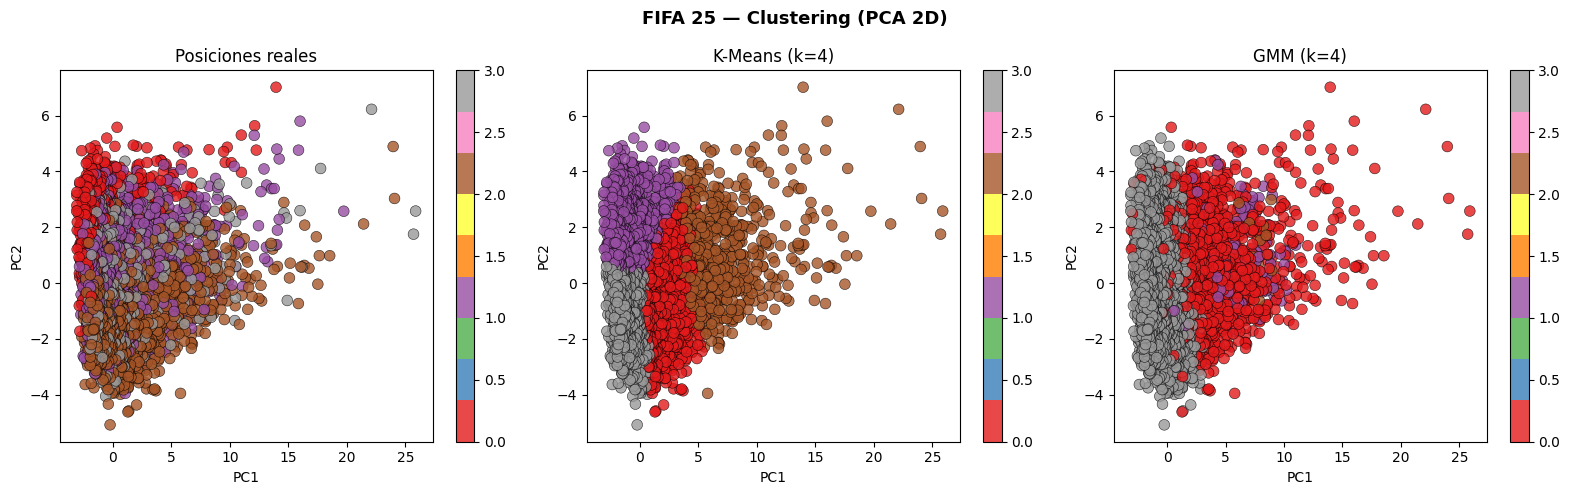

In [ ]:
pca       = PCA(n_components=2)
X_fifa_2d = pca.fit_transform(X_fifa)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, lbl, title in zip(axes,
        [y_fifa, labels_km_fifa, labels_gmm_fifa],
        ['Posiciones reales', f'K-Means (k={K_FIFA})', f'GMM (k={K_FIFA})']):
    sc = ax.scatter(X_fifa_2d[:, 0], X_fifa_2d[:, 1],
                    c=lbl, cmap='Set1', alpha=0.8, edgecolors='k', linewidth=0.4, s=60)
    ax.set_title(title); ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
    plt.colorbar(sc, ax=ax)
plt.suptitle('FIFA 25 — Clustering (PCA 2D)', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

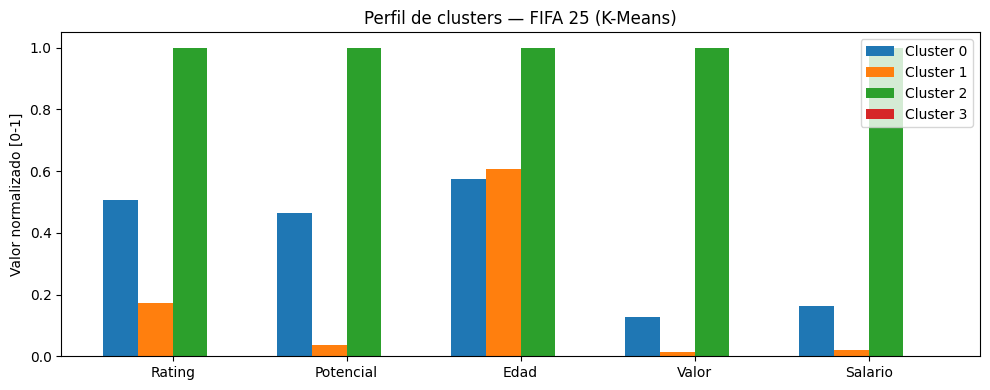

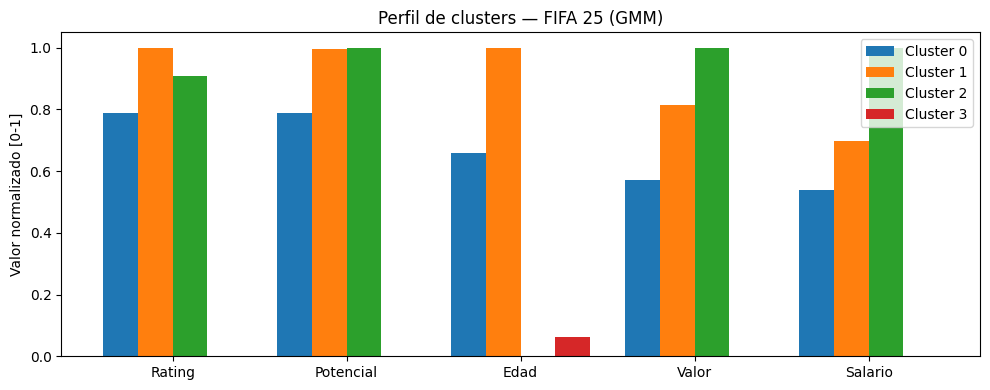

=== Medias por cluster — K-Means ===
            overall_rating  potential   age   value_num  wage_num
cluster_km                                                       
0                     71.9       75.5  27.5   4974798.3   20667.4
1                     65.2       69.5  27.6   1208686.8    8911.0
2                     81.7       82.9  29.6  33363802.6   88970.7
3                     61.8       69.0  24.6    774165.2    7339.2

=== Medias por cluster — GMM ===
             overall_rating  potential   age   value_num  wage_num
cluster_gmm                                                       
0                      77.3       79.5  29.0  18282378.9   54645.3
1                      80.6       82.0  30.6  25489851.5   67742.6
2                      79.1       82.0  26.0  30960294.1   92941.2
3                      65.1       70.4  26.3   1468780.3    9745.4


In [ ]:
df_clean_copy                = df_clean.copy()
df_clean_copy['cluster_km']  = labels_km_fifa
df_clean_copy['cluster_gmm'] = labels_gmm_fifa

vars_bar  = ['overall_rating', 'potential', 'age', 'value_num', 'wage_num']
lbl_bar   = ['Rating', 'Potencial', 'Edad', 'Valor', 'Salario']

for algo, col in [('K-Means', 'cluster_km'), ('GMM', 'cluster_gmm')]:
    means      = df_clean_copy.groupby(col)[vars_bar].mean()
    means_norm = (means - means.min()) / (means.max() - means.min() + 1e-9)
    x, w       = np.arange(len(lbl_bar)), 0.8 / K_FIFA
    fig, ax    = plt.subplots(figsize=(10, 4))
    for i, cid in enumerate(means_norm.index):
        ax.bar(x + i * w, means_norm.loc[cid], w, label=f'Cluster {cid}')
    ax.set_xticks(x + w * (K_FIFA - 1) / 2)
    ax.set_xticklabels(lbl_bar)
    ax.set_ylabel('Valor normalizado [0-1]')
    ax.set_title(f'Perfil de clusters — FIFA 25 ({algo})')
    ax.legend(); plt.tight_layout(); plt.show()

print("=== Medias por cluster — K-Means ===")
print(df_clean_copy.groupby('cluster_km')[vars_bar].mean().round(1).to_string())
print("\n=== Medias por cluster — GMM ===")
print(df_clean_copy.groupby('cluster_gmm')[vars_bar].mean().round(1).to_string())

### 1.3.7 Cluster description — FIFA 25

> **Instruccion:** completa cada fila usando los valores de la tabla de medias y el bar chart.

**Que observar en el bar chart:**
- Barras altas en *Rating* + *Valor* + *Salario* → jugadores de elite.
- Barras altas en *Potencial* + baja *Edad* → promesas / jovenes.
- Barras bajas en todo → jugadores de menor nivel o en retiro.
- Alto en *Edad* + bajo en resto → veteranos con menor valor de mercado.

#### K-Means

| Cluster | Rating | Potencial | Edad | Valor (M€) | Nombre sugerido | Interpretacion |
|---|---|---|---|---|---|---|
| 0 | *(completar)* | *(completar)* | *(completar)* | *(completar)* | ***(completar)*** | *(completar)* |
| 1 | *(completar)* | *(completar)* | *(completar)* | *(completar)* | ***(completar)*** | *(completar)* |
| 2 | *(completar)* | *(completar)* | *(completar)* | *(completar)* | ***(completar)*** | *(completar)* |
| 3 | *(completar)* | *(completar)* | *(completar)* | *(completar)* | ***(completar)*** | *(completar)* |

#### GMM

| Cluster | Rating | Potencial | Edad | Valor (M€) | Nombre sugerido | Interpretacion |
|---|---|---|---|---|---|---|
| 0 | *(completar)* | *(completar)* | *(completar)* | *(completar)* | ***(completar)*** | *(completar)* |
| 1 | *(completar)* | *(completar)* | *(completar)* | *(completar)* | ***(completar)*** | *(completar)* |
| 2 | *(completar)* | *(completar)* | *(completar)* | *(completar)* | ***(completar)*** | *(completar)* |
| 3 | *(completar)* | *(completar)* | *(completar)* | *(completar)* | ***(completar)*** | *(completar)* |

#### Conclusion

- Los clusters de K-Means y GMM capturan grupos similares? *(completar)*
- Los clusters se corresponden con las posiciones reales? Comentar el Rand Index obtenido. *(completar)*
- Cual algoritmo produce grupos mas interpretables? *(justificar)*

## 1.4 Dataset: East West Airlines

**Objetivo:** identificar segmentos de clientes segun su comportamiento de vuelo y uso de beneficios.

**Features:** Balance, Qual miles, CC miles (x3), Bonus miles, Bonus trans, Flight miles 12mo, Flight trans 12, Days since enroll.

**Numero de clusters:** no hay etiquetas naturales como en FIFA, por eso `K_AIR` se elige con ayuda del Elbow y Silhouette (ver seccion 1.4.2). Una vez vista la grafica, ajusta el valor y vuelve a ejecutar las celdas siguientes.

### 1.4.1 Preprocessing

In [ ]:
df_air = pd.read_excel('EastWestAirlines.xlsx', sheet_name='data')

features_air = ['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
                'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo',
                'Flight_trans_12', 'Days_since_enroll']

df_air_clean = df_air[features_air].dropna()
y_air        = df_air.loc[df_air_clean.index, 'Award?'].values
scaler_air   = StandardScaler()
X_air        = scaler_air.fit_transform(df_air_clean)

print(f"Clientes disponibles: {X_air.shape[0]}")
df_air_clean.describe()

Clientes disponibles: 38


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
count,38.000000,38.000000,38.000000,38.000000,38.0,38.000000,38.000000,38.000000,38.000000,38.000000
mean,73396.657895,66.421053,2.026316,1.026316,1.0,15059.105263,11.289474,497.473684,1.605263,7284.526316
std,87405.292783,336.071472,1.345399,0.162221,0.0,19526.423896,10.456882,976.413950,3.027259,469.132191
min,8828.000000,0.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,6884.000000
25%,19579.000000,0.000000,1.000000,1.000000,1.0,537.500000,2.000000,0.000000,0.000000,6913.500000
50%,42225.500000,0.000000,1.000000,1.000000,1.0,4207.000000,9.000000,0.000000,0.000000,6955.500000
75%,95259.750000,0.000000,3.000000,1.000000,1.0,27463.500000,19.750000,462.500000,2.000000,7867.250000
max,443003.000000,2024.000000,5.000000,2.000000,1.0,61105.000000,43.000000,3850.000000,12.000000,7932.000000


### 1.4.2 Elbow and Silhouette — choosing K_AIR

Se evaluan varias opciones de k para guiar la eleccion del numero optimo de clusters.

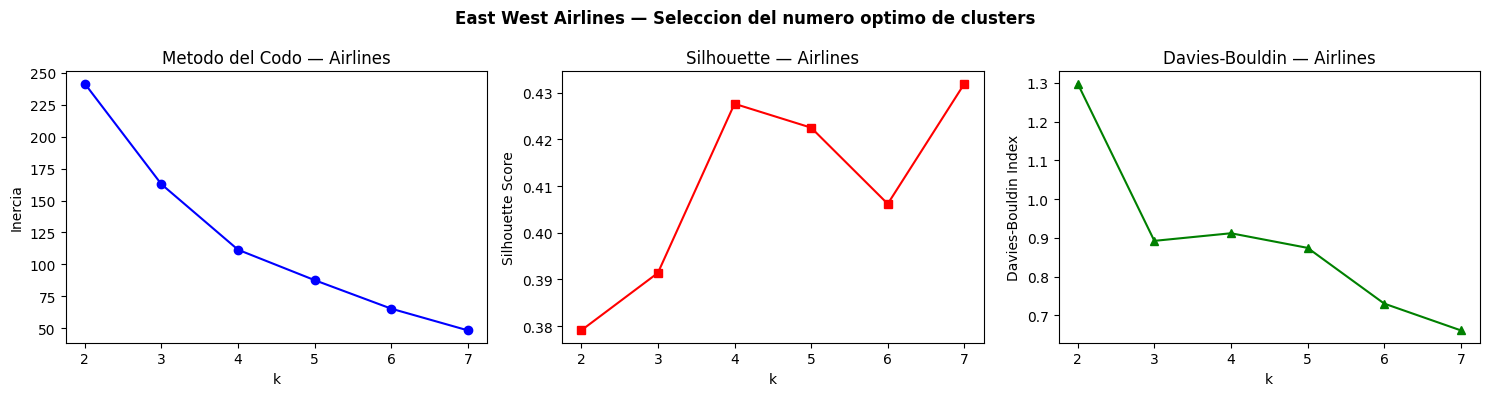

 k |    Inercia | Silhouette | DB Index
----------------------------------------
 2 |     241.40 |     0.3791 |   1.2979
 3 |     162.73 |     0.3914 |   0.8921
 4 |     111.49 |     0.4276 |   0.9117
 5 |      87.70 |     0.4225 |   0.8740
 6 |      65.39 |     0.4062 |   0.7301
 7 |      48.42 |     0.4319 |   0.6610


In [ ]:
# Rango a explorar para Airlines. Por defecto k=2..7.
# Cambia los limites si quieres explorar mas opciones.
k_range_air = range(2, 8)

inertias_air    = []
silhouettes_air = []
db_scores_air   = []

for k in k_range_air:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_air)
    inertias_air.append(km.inertia_)
    silhouettes_air.append(silhouette_score(X_air, km.labels_))
    db_scores_air.append(davies_bouldin_score(X_air, km.labels_))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(list(k_range_air), inertias_air,    'bo-')
axes[0].set_xlabel('k'); axes[0].set_ylabel('Inercia')
axes[0].set_title('Metodo del Codo — Airlines')
axes[1].plot(list(k_range_air), silhouettes_air, 'rs-')
axes[1].set_xlabel('k'); axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette — Airlines')
axes[2].plot(list(k_range_air), db_scores_air,   'g^-')
axes[2].set_xlabel('k'); axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin — Airlines')
plt.suptitle('East West Airlines — Seleccion del numero optimo de clusters', fontweight='bold')
plt.tight_layout(); plt.show()

print(f"{'k':>2} | {'Inercia':>10} | {'Silhouette':>10} | {'DB Index':>8}")
print('-' * 40)
for i, k in enumerate(k_range_air):
    print(f"{k:>2} | {inertias_air[i]:>10.2f} | {silhouettes_air[i]:>10.4f} | {db_scores_air[i]:>8.4f}")

### 1.4.3 K selection — Airlines

> **Instruccion:** observa las graficas y la tabla anteriores, luego completa el analisis y actualiza `K_AIR` en la celda siguiente.

| Grafica | Que buscar | Senal del k optimo |
|---|---|---|
| Metodo del Codo | Punto donde la inercia deja de caer abruptamente | El codo de la curva |
| Silhouette Score | Maximo de la curva | k con el valor mas alto |
| Davies-Bouldin | Minimo de la curva | k con el valor mas bajo |

- **Metodo del Codo:** *(completar — ej: la caida mas pronunciada ocurre entre k=__ y k=__)*
- **Silhouette Score:** *(completar — ej: el maximo se alcanza en k=__ con valor de __)*
- **Davies-Bouldin:** *(completar — ej: el minimo se obtiene en k=__ con valor de __)*

**→ k elegido: `K_AIR = ___`** — *(justificar brevemente)*

### 1.4.4 Clustering — K-Means and GMM

> Actualiza `K_AIR` con el valor elegido en la seccion 1.4.3 y ejecuta esta celda.

K_AIR = 3
Distribucion K-Means: [23 14  1]
Distribucion GMM:     [10 21  7]


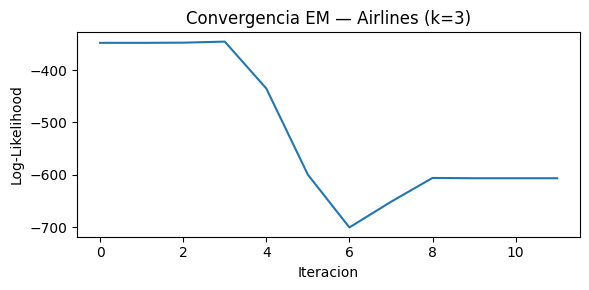

In [ ]:
# Ajustar K_AIR segun el analisis de la seccion 1.3.2 (Elbow / Silhouette).
# Una vez vistas las graficas, cambia este valor y vuelve a ejecutar la celda.
K_AIR = 3

km_air        = KMeans(n_clusters=K_AIR, random_state=42, n_init=10)
labels_km_air = km_air.fit_predict(X_air)

gmm_air = GMM(n_components=K_AIR, max_iters=200)
gmm_air.fit(X_air)
labels_gmm_air = gmm_air.predict(X_air)

print(f"K_AIR = {K_AIR}")
print("Distribucion K-Means:", np.bincount(labels_km_air))
print("Distribucion GMM:    ", np.bincount(labels_gmm_air))

plt.figure(figsize=(6, 3))
plt.plot(gmm_air.log_likelihoods_)
plt.xlabel('Iteracion'); plt.ylabel('Log-Likelihood')
plt.title(f'Convergencia EM — Airlines (k={K_AIR})')
plt.tight_layout(); plt.show()

### 1.4.5 Quantitative evaluation — Rand Index and metrics

In [ ]:
res_km_air  = evaluar_clustering(X_air, labels_km_air,  y_air, 'K-Means', inertia=km_air.inertia_)
res_gmm_air = evaluar_clustering(X_air, labels_gmm_air, y_air, 'GMM')

df_metricas_air = pd.DataFrame([res_km_air, res_gmm_air]).set_index('Metodo')
display(df_metricas_air)

,Silhouette ↑,Davies-Bouldin ↓,Inercia ↓,Rand Index ↑,Adj. Rand Index ↑
Metodo,,,,,
K-Means,0.3914,0.8921,162.73,0.6202,0.2404
GMM,0.1496,3.3802,N/A,0.5690,0.1377


### 1.4.6 Qualitative evaluation — scatter plot and cluster profiles

Scatter plot en 2D (PCA) y bar chart de perfiles normalizados para interpretar cada cluster.

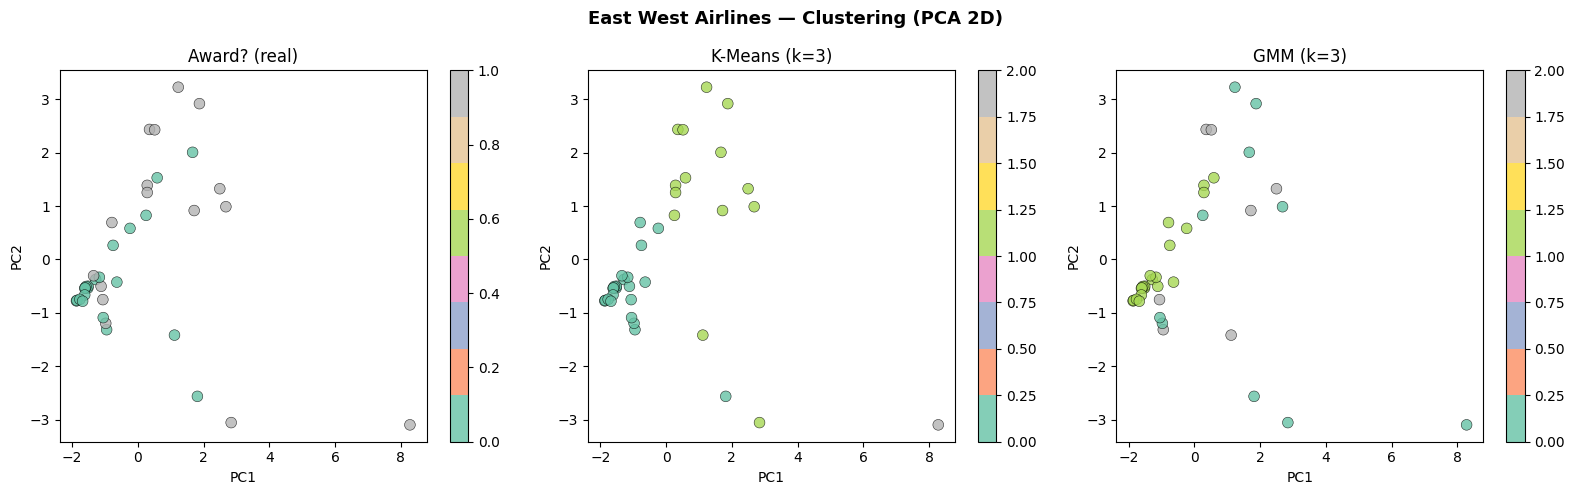

In [ ]:
pca_air  = PCA(n_components=2)
X_air_2d = pca_air.fit_transform(X_air)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, lbl, title in zip(axes,
        [y_air, labels_km_air, labels_gmm_air],
        ['Award? (real)', f'K-Means (k={K_AIR})', f'GMM (k={K_AIR})']):
    sc = ax.scatter(X_air_2d[:, 0], X_air_2d[:, 1],
                    c=lbl, cmap='Set2', alpha=0.8, edgecolors='k', linewidth=0.4, s=60)
    ax.set_title(title); ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
    plt.colorbar(sc, ax=ax)
plt.suptitle('East West Airlines — Clustering (PCA 2D)', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

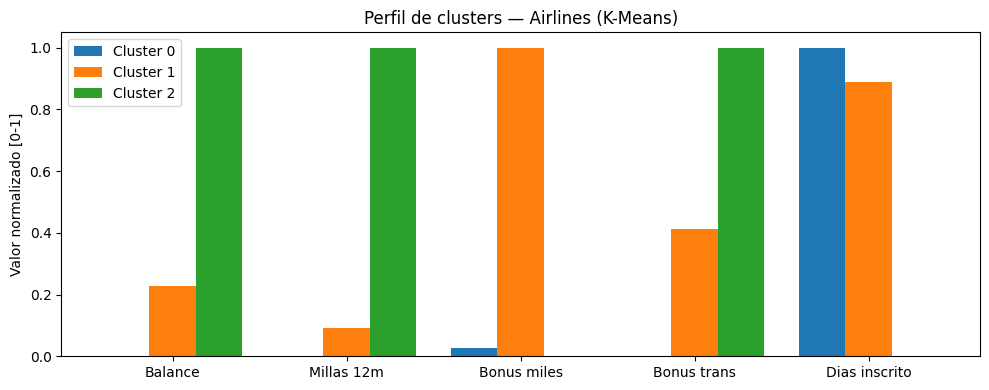

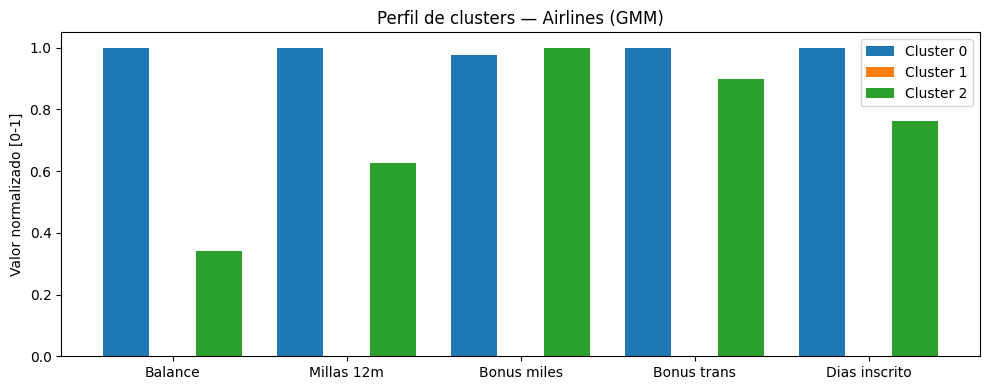

=== Medias por cluster — K-Means ===
             Balance  Flight_miles_12mo  Bonus_miles  Bonus_trans  Days_since_enroll
cluster_km                                                                          
0            27836.4              281.6       2653.3          4.4             7308.7
1           121845.2              612.6      36390.5         20.4             7268.8
2           443003.0             3850.0       1753.0         43.0             6948.0

=== Medias por cluster — GMM ===
              Balance  Flight_miles_12mo  Bonus_miles  Bonus_trans  Days_since_enroll
cluster_gmm                                                                          
0            153648.1             1275.0      25285.2         17.7             7389.3
1             34581.0               23.8       6636.0          6.5             7213.6
2             75198.6              807.7      25719.7         16.6             7347.6


In [ ]:
df_air_copy                = df_air_clean.copy()
df_air_copy['cluster_km']  = labels_km_air
df_air_copy['cluster_gmm'] = labels_gmm_air

vars_air = ['Balance', 'Flight_miles_12mo', 'Bonus_miles', 'Bonus_trans', 'Days_since_enroll']
lbl_air  = ['Balance', 'Millas 12m', 'Bonus miles', 'Bonus trans', 'Dias inscrito']

for algo, col in [('K-Means', 'cluster_km'), ('GMM', 'cluster_gmm')]:
    means      = df_air_copy.groupby(col)[vars_air].mean()
    means_norm = (means - means.min()) / (means.max() - means.min() + 1e-9)
    x, w       = np.arange(len(lbl_air)), 0.8 / K_AIR
    fig, ax    = plt.subplots(figsize=(10, 4))
    for i, cid in enumerate(means_norm.index):
        ax.bar(x + i * w, means_norm.loc[cid], w, label=f'Cluster {cid}')
    ax.set_xticks(x + w * (K_AIR - 1) / 2)
    ax.set_xticklabels(lbl_air)
    ax.set_ylabel('Valor normalizado [0-1]')
    ax.set_title(f'Perfil de clusters — Airlines ({algo})')
    ax.legend(); plt.tight_layout(); plt.show()

print("=== Medias por cluster — K-Means ===")
print(df_air_copy.groupby('cluster_km')[vars_air].mean().round(1).to_string())
print("\n=== Medias por cluster — GMM ===")
print(df_air_copy.groupby('cluster_gmm')[vars_air].mean().round(1).to_string())

### 1.4.7 Cluster description — East West Airlines

> **Instruccion:** completa cada fila usando los valores de la tabla de medias y el bar chart.

**Que observar en el bar chart:**
- Barras altas en *Balance* + *Millas 12m* + *Bonus miles* → cliente frecuente premium.
- Barras altas en *Dias inscrito* + balance moderado → cliente leal pero poco activo.
- Barras bajas en todo → cliente nuevo o inactivo.
- Alto en *Bonus trans* + bajo *Balance* → acumula por transacciones, no por vuelos.

#### K-Means

| Cluster | Balance | Millas 12m | Bonus miles | Dias inscrito | Nombre sugerido | Interpretacion |
|---|---|---|---|---|---|---|
| 0 | *(completar)* | *(completar)* | *(completar)* | *(completar)* | ***(completar)*** | *(completar)* |
| 1 | *(completar)* | *(completar)* | *(completar)* | *(completar)* | ***(completar)*** | *(completar)* |
| 2 | *(completar)* | *(completar)* | *(completar)* | *(completar)* | ***(completar)*** | *(completar)* |

#### GMM

| Cluster | Balance | Millas 12m | Bonus miles | Dias inscrito | Nombre sugerido | Interpretacion |
|---|---|---|---|---|---|---|
| 0 | *(completar)* | *(completar)* | *(completar)* | *(completar)* | ***(completar)*** | *(completar)* |
| 1 | *(completar)* | *(completar)* | *(completar)* | *(completar)* | ***(completar)*** | *(completar)* |
| 2 | *(completar)* | *(completar)* | *(completar)* | *(completar)* | ***(completar)*** | *(completar)* |

#### Conclusion

- Los clusters tienen una interpretacion de negocio clara? *(completar)*
- El clustering se relaciona con la variable `Award?`? Comentar el Rand Index. *(completar)*
- Que estrategia de fidelizacion sugeriria para cada segmento? *(completar)*

---
# Assignment 2: Evaluating Clustering with Elbow and Silhouette Methods

**Tasks:**
1. Implement the Elbow method and Silhouette analysis for both datasets.
2. Apply both K-Means and GMM and compare their performance in determining the optimal k.
3. Evaluate clustering quality using four metrics: Silhouette Score, Inertia, Davies-Bouldin Index, Rand Index.
4. Discuss how the choice of k impacts each metric and recommend the optimal number of clusters.

## 2.1 FIFA 25 — Elbow, Silhouette and Metrics Comparison

*(Los datos ya fueron cargados en la seccion 1.3.1)*

### 2.1.1 Elbow method and Silhouette analysis — K-Means

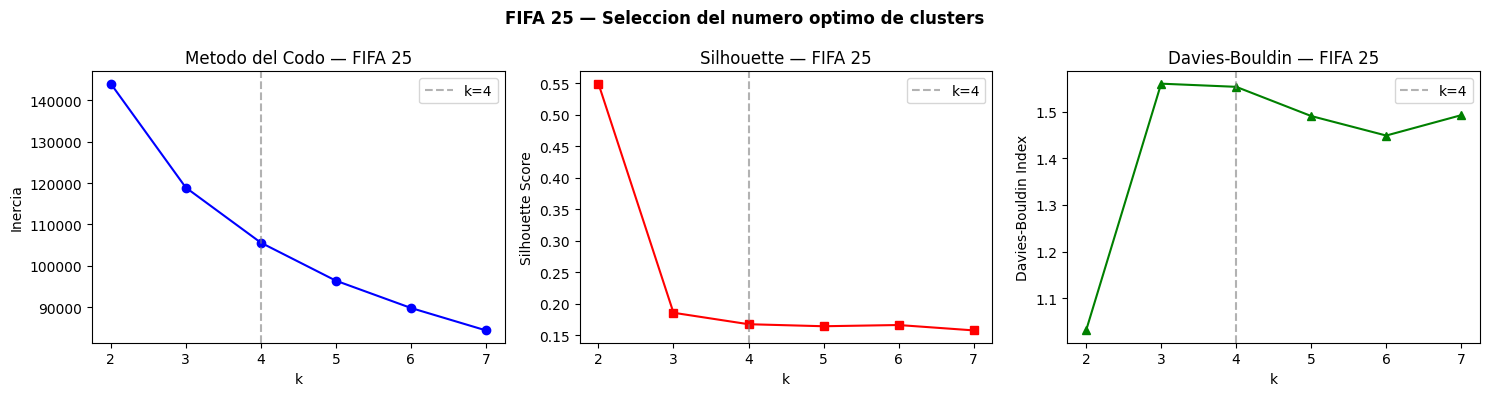

 k |    Inercia | Silhouette | DB Index
----------------------------------------
 2 |  144033.90 |     0.5495 |   1.0308
 3 |  118901.13 |     0.1858 |   1.5602
 4 |  105579.57 |     0.1676 |   1.5534 <-- default
 5 |   96387.73 |     0.1644 |   1.4907
 6 |   89792.00 |     0.1664 |   1.4489
 7 |   84365.23 |     0.1578 |   1.4926


In [ ]:
# Rango usado en Assignment 2 — puede diferir del de Assignment 1
# si quieres una vista mas amplia para la comparacion.
k_range_fifa2 = range(2, 8)

inertias_fifa    = []
silhouettes_fifa = []
db_scores_fifa   = []

for k in k_range_fifa2:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_fifa)
    inertias_fifa.append(km.inertia_)
    silhouettes_fifa.append(silhouette_score(X_fifa, km.labels_))
    db_scores_fifa.append(davies_bouldin_score(X_fifa, km.labels_))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(list(k_range_fifa2), inertias_fifa,    'bo-')
axes[0].axvline(x=4, color='gray', linestyle='--', alpha=0.6, label='k=4')
axes[0].set_xlabel('k'); axes[0].set_ylabel('Inercia')
axes[0].set_title('Metodo del Codo — FIFA 25'); axes[0].legend()
axes[1].plot(list(k_range_fifa2), silhouettes_fifa, 'rs-')
axes[1].axvline(x=4, color='gray', linestyle='--', alpha=0.6, label='k=4')
axes[1].set_xlabel('k'); axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette — FIFA 25'); axes[1].legend()
axes[2].plot(list(k_range_fifa2), db_scores_fifa,   'g^-')
axes[2].axvline(x=4, color='gray', linestyle='--', alpha=0.6, label='k=4')
axes[2].set_xlabel('k'); axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin — FIFA 25'); axes[2].legend()
plt.suptitle('FIFA 25 — Seleccion del numero optimo de clusters', fontweight='bold')
plt.tight_layout(); plt.show()

print(f"{'k':>2} | {'Inercia':>10} | {'Silhouette':>10} | {'DB Index':>8}")
print('-' * 40)
for i, k in enumerate(k_range_fifa2):
    mark = ' <-- default' if k == 4 else ''
    print(f"{k:>2} | {inertias_fifa[i]:>10.2f} | {silhouettes_fifa[i]:>10.4f} | {db_scores_fifa[i]:>8.4f}{mark}")

### 2.1.2 K-Means vs GMM — four metrics at K = 4

*(Los resultados de clustering ya fueron calculados en la seccion 1.3.2)*

In [ ]:
# df_metricas_fifa fue calculado en la seccion 1.3.5
print('=== Metricas de evaluacion — FIFA 25 ===')
display(df_metricas_fifa)

=== Metricas de evaluacion — FIFA 25 ===


,Silhouette ↑,Davies-Bouldin ↓,Inercia ↓,Rand Index ↑,Adj. Rand Index ↑
Metodo,,,,,
K-Means,0.1676,1.5534,105579.57,0.6048,0.0946
GMM,0.4213,2.6542,N/A,0.3794,0.0008


### 2.1.3 Discussion — impact of k on metrics (FIFA 25)

> **Instruccion:** completa con los valores de la tabla de la seccion 2.1.1.

| Metrica | Tendencia al aumentar k | Interpretacion |
|---|---|---|
| **Silhouette ↑** | Varia, tiene un maximo | El k optimo maximiza la cohesion interna vs. separacion entre clusters |
| **Inercia ↓** | Decrece monotonamente | El Metodo del Codo busca el punto de inflexion donde la ganancia se vuelve marginal |
| **Davies-Bouldin ↓** | Varia, tiene un minimo | Valores bajos indican clusters bien separados y compactos |
| **Rand Index ↑** | Depende de la estructura real | Compara con las posiciones reales; no mejora necesariamente al aumentar k |

**Analisis para FIFA 25:**
- Con k=2 el Silhouette es ___, con k=___ alcanza su maximo de ___.
- La inercia pasa de ___ (k=2) a ___ (k=7); el codo mas claro se observa en k=___.
- El Davies-Bouldin se minimiza en k=___ con valor de ___.
- El Rand Index de K-Means es ___ y el Adj. Rand Index es ___; para GMM son ___ y ___.
- **k recomendado:** ___ *(justificar con base en los tres indicadores)*

## 2.2 East West Airlines — Elbow, Silhouette and Metrics Comparison

*(Los datos ya fueron cargados en la seccion 1.4.1)*

### 2.2.1 Elbow method and Silhouette analysis — K-Means

*(Las graficas ya fueron generadas en la seccion 1.4.2 — se reutilizan los valores)*

In [ ]:
print('=== Tabla de metricas por k — Airlines ===')
print(f"{'k':>2} | {'Inercia':>10} | {'Silhouette':>10} | {'DB Index':>8}")
print('-' * 40)
for i, k in enumerate(k_range_air):
    print(f"{k:>2} | {inertias_air[i]:>10.2f} | {silhouettes_air[i]:>10.4f} | {db_scores_air[i]:>8.4f}")

=== Tabla de metricas por k — Airlines ===
 k |    Inercia | Silhouette | DB Index
----------------------------------------
 2 |     241.40 |     0.3791 |   1.2979
 3 |     162.73 |     0.3914 |   0.8921
 4 |     111.49 |     0.4276 |   0.9117
 5 |      87.70 |     0.4225 |   0.8740
 6 |      65.39 |     0.4062 |   0.7301
 7 |      48.42 |     0.4319 |   0.6610


### 2.2.2 K-Means vs GMM — four metrics at chosen K

*(Los resultados de clustering ya fueron calculados en la seccion 1.4.4)*

In [ ]:
# df_metricas_air fue calculado en la seccion 1.4.5
print('=== Metricas de evaluacion — East West Airlines ===')
display(df_metricas_air)

=== Metricas de evaluacion — East West Airlines ===


,Silhouette ↑,Davies-Bouldin ↓,Inercia ↓,Rand Index ↑,Adj. Rand Index ↑
Metodo,,,,,
K-Means,0.3914,0.8921,162.73,0.6202,0.2404
GMM,0.1496,3.3802,N/A,0.5690,0.1377


### 2.2.3 Discussion — impact of k on metrics (Airlines)

> **Instruccion:** completa con los valores de la tabla de la seccion 1.4.2.

| Metrica | Tendencia al aumentar k | Interpretacion |
|---|---|---|
| **Silhouette ↑** | Varia, tiene un maximo | El k optimo maximiza la cohesion interna vs. separacion |
| **Inercia ↓** | Decrece monotonamente | El Metodo del Codo busca el punto de inflexion |
| **Davies-Bouldin ↓** | Varia, tiene un minimo | Valores bajos indican clusters bien separados y compactos |
| **Rand Index ↑** | Depende de la estructura real | Compara con la etiqueta `Award?`; no mejora necesariamente al aumentar k |

**Analisis para Airlines:**
- Con k=2 el Silhouette es ___, con k=___ alcanza su maximo de ___.
- La inercia pasa de ___ (k=2) a ___ (k=7); el codo mas claro se observa en k=___.
- El Davies-Bouldin se minimiza en k=___ con valor de ___.
- El Rand Index de K-Means es ___ y el Adj. Rand Index es ___; para GMM son ___ y ___.
- **k recomendado:** ___ *(justificar con base en los tres indicadores)*

---
# Summary of Results and Analysis

Resumen comparativo de metricas para ambos datasets y ambos algoritmos.

In [ ]:
print("=" * 62)
print("RESUMEN DE METRICAS — FIFA 25")
print("=" * 62)
display(df_metricas_fifa)
print()
print("=" * 62)
print("RESUMEN DE METRICAS — EAST WEST AIRLINES")
print("=" * 62)
display(df_metricas_air)

RESUMEN DE METRICAS — FIFA 25


,Silhouette ↑,Davies-Bouldin ↓,Inercia ↓,Rand Index ↑,Adj. Rand Index ↑
Metodo,,,,,
K-Means,0.1676,1.5534,105579.57,0.6048,0.0946
GMM,0.4213,2.6542,N/A,0.3794,0.0008



RESUMEN DE METRICAS — EAST WEST AIRLINES


,Silhouette ↑,Davies-Bouldin ↓,Inercia ↓,Rand Index ↑,Adj. Rand Index ↑
Metodo,,,,,
K-Means,0.3914,0.8921,162.73,0.6202,0.2404
GMM,0.1496,3.3802,N/A,0.5690,0.1377


## K-Means vs GMM — Comparison

| Aspecto | K-Means | GMM |
|---|---|---|
| Forma de cluster asumida | Esferica | Eliptica / flexible |
| Tipo de asignacion | Dura (un cluster por punto) | Suave (probabilidad de pertenencia) |
| Inercia calculable | Si | No aplica directamente |
| Convergencia | Iteraciones sobre centroides | Iteraciones EM |
| Mejor cuando | Clusters compactos y bien separados | Clusters superpuestos o con formas irregulares |

*(Completar: cual algoritmo fue mas adecuado para cada dataset y por que?)*